## Сделаем простенький алгоритм предсказывания значения Target на основе Target от предыдущего объекта (target_p). Датафрейм возьмём сделанный ранее

In [1]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import xgboost

In [2]:
# Прочитаем полученный ранее в "4_Prev_Feautures" 
data_train = pd.read_csv('data_P.csv')

In [3]:
features = [feature for feature in data_train.columns if feature not in ['id', 'id_p', 'target']]

In [4]:
# Выделяем признаки и целевой признак
y_train = np.array(data_train['target'])
X_train = np.array(data_train[features])

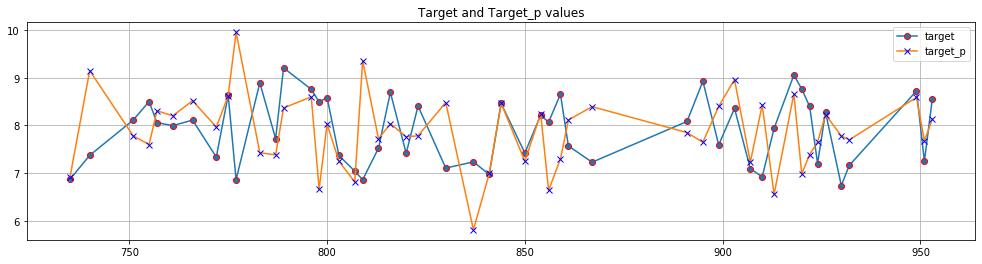

In [5]:
# Посмотрим визуально на разброс между значениями Target и Target_p
target = data_train['target']
target_p = data_train['target_p']
plt.figure(figsize=(17,4))
plt.plot(data_train['id'][150:200], target[150:200], marker ='o', markeredgecolor = 'red', label ='target')
plt.plot(data_train['id'][150:200], target_p[150:200], marker ='x', markeredgecolor = 'blue', label = 'target_p')
plt.title('Target and Target_p values')
plt.legend()
plt.grid()

In [6]:
print ('Среднее между модулем разности значений Target и Target_p:', np.round( np.mean(abs(target - target_p)), 4))

Среднее между модулем разности значений Target и Target_p: 0.8347


In [7]:
print ('Длина тренировочного набора данных:', len(data_train))

Длина тренировочного набора данных: 112508


### Попробуем подобрать оптимальные параметры, при которых, смещая значение target_p на некоторую величину, будем получать величину target с наименьшей ошибкой на нашей тренировочной выборке

In [8]:
%%time
# Будем прибавлять какое-то значение к величине target_p и получать предсказания для Target.
# Найдём так же значение от которого нужно производить сложение с величиной target_p, а ниже которого вычитание.
# Формулу рассчёта значения target запишем таким образом, чтобы добавл. или уменьш. значения от target_p производилось мягко

shifts = np.arange(0.3, 0.6, 0.005)            # Массив сдвигов (как сильно мы будем смещать значение Target_p)
centres = np.arange(7, 8.5, 0.1)               # Центры (От какого значения мы будем производить смещение вверх или вниз)
minimum = 1
centre_best, shift_best = 0, 0                 # Лучшие гиперпараметры, инициализируем нулями
for shift in shifts:
    for centre in centres:
        target_new = []                         # Формируем новый список с "предсказаниями"
        for tar in target_p:                    # Перебираем значения Предыдущего Таргета
            if tar < centre:                    # Если значение Предыдущего Таргета меньше порога
                target_new.append(tar + (1+abs(tar-centre))*shift)   # Добавляем к нему сдвиг и получаем предсказание Таргета
            else:
                target_new.append(tar - (1+abs(tar-centre))*shift)   # Если выше порога, отнимаем
            
        mae_iter = np.mean(abs(target-target_new))  # Ошибка полученных предсказаний, относительно тренировочной выборки Таргет
        if mae_iter < minimum:       # Если нашли новую минимальную ошибку
            minimum = mae_iter;      # Обозначаем новый минимум глобальный
            centre_best = centre;    # Сохраняем гиперпараметры для минимума глобального
            shift_best = shift;
        
print ('Глобальный минимум MAE на тренировочной выборке', minimum)
print ('Лучшее значение для разделения:', np.round(centre_best,3), 'Лучший сдвиг :', np.round(shift_best,3))  

Глобальный минимум MAE на тренировочной выборке 0.6385015398298777
Лучшее значение для разделения: 8.0 Лучший сдвиг : 0.42
Wall time: 2min 20s


#### Заполним массив предсказаний preds там, где поле Target = NaN первое после предыдущего объекта с заполненным Target. ( то есть, так, как мы сделали нашу модель ).

In [9]:
data_test = pd.read_csv('test.csv') 
data_ = pd.read_csv('train.csv') 
data_test.index=data_test['id'].tolist()
data_.index=data_['id'].tolist()
data = data_.append(data_test)
data = data.sort_values(by = ['id'])

In [10]:
import math
preds = []
for i in range(len(data['target'])):
    if i>0:
        if (math.isnan(data['target'][i]) == True) and math.isnan(data['target'][i-1]) == False: # если условие предсказания
            # Делаем предсказание для Target
            if data['target'][i-1] < centre_best:
                target_val = data['target'][i-1] + (1+abs(data['target'][i-1]-centre_best))*shift_best
            else:
                target_val = data['target'][i-1] - (1+abs(data['target'][i-1]-centre_best))*shift_best
            preds.append(target_val)     # добавляем предсказанное значение target
            
        elif math.isnan(data['target'][i]) == True:   # если просто пустое поле таргет
            preds.append(0)   # добавляем нулевое предсказание (их сделаем через машинную модель)
    else:
        preds.append(0)       # добавляем первый нулевой элемент (к id0)

In [11]:
print('Длина полученного списка с предсказания соотв. длине тестового DF? -',len(preds) == data_test.shape[0])
print('Полученная длина списка предсказаний:', len(preds))

Длина полученного списка с предсказания соотв. длине тестового DF? - True
Полученная длина списка предсказаний: 200000


***Посмотрим и убедимся, что всё верно***

In [12]:
print (np.round(preds[:10],3), '\n')

print (np.round(data.loc[:, 'target'][:12].tolist(),3))

[0.    7.981 7.815 0.    8.041 7.894 8.247 0.    0.    0.   ] 

[  nan 7.243   nan 8.203 7.776 6.958   nan   nan 7.951 7.347   nan 8.616]


***Кажется, всё заполнено правильно***

In [13]:
print ('Итоговое кол-во предсказаний "ручного" алгоритма:', sum([element>0 for element in preds]),' из нужных', len(preds) )

Итоговое кол-во предсказаний "ручного" алгоритма: 120093  из нужных 200000


***Получился неполный список с предсказаниями для тестовой выборке. Т.к не все объекты удовлетворяют нашим условиям. Ответы на остальных объектах заполним нашим лучшим алгоритмом***

***Загрузим наш наиболее успешный алгоритм на паблик скорах: Композиция случайных лесов с разным признаковым пространсттвом***

In [14]:
sub_preds_RF = pd.read_csv('RF_minusoneFeature.csv')

In [15]:
sub_preds_RF.head()

,id,target
0,0,7.925924
1,2,7.875958
2,6,7.918909
3,7,8.239393
4,10,8.155506


In [16]:
preds_RF = sub_preds_RF['target'].tolist()
print ('Лучшие предсказания на паблик скоре от случайного леса', np.round(preds_RF[:10],3))
print ('Длина списка предсказаний:', len(preds_RF))

Лучшие предсказания на паблик скоре от случайного леса [7.926 7.876 7.919 8.239 8.156 7.923 8.272 7.739 7.923 7.723]
Длина списка предсказаний: 200000


***Создадим список с итоговыми предсказаниями. В позиции с нулевым (0) ответом нашего ручного алгоритма, 
будем подставлять ответ модели случайных лесов***

In [17]:
preds_total_new = []                          # Список с итоговыми ответами
for i in range(len(preds)):
    if preds[i] == 0.:
        preds_total_new.append(preds_RF[i])   # Если наше ручное предсказание пустое, добавляем предсказания от RF
    else:
        preds_total_new.append(preds[i])      # Иначе, добавляем наше предсказание

In [18]:
sub = pd.read_csv('sample_submission.csv') # csv с ответами
sub['target'] = preds_total_new
print(sub.head())
sub.to_csv('Look_at_TargetP_4.csv', index=False)

   id    target
0   0  7.925924
1   2  7.980965
2   6  7.815475
3   7  8.239393
4  10  8.041187


***Public score 0.74326. Очень сильно подстроились под нашу тренировочную выборку*** 

### Попробуем изменить доли вклада нашей текущей модели и RF

In [19]:
preds_total_3 = np.array(preds_total_new)*0.02 + np.array(preds_RF)*0.98

In [20]:
preds_total_3

array([7.9259243 , 7.87805842, 7.91684006, ..., 8.17699319, 8.03795172,
       7.94885462])

In [21]:
sub = pd.read_csv('sample_submission.csv') # csv с ответами
sub['target'] = preds_total_3
print(sub.head())
sub.to_csv('Look_at_TargetP_555.csv', index=False)

   id    target
0   0  7.925924
1   2  7.878058
2   6  7.916840
3   7  8.239393
4  10  8.153219


***Public score 0.69916. Что хуже, чем просто RF с 0.69914***

## Попробуем сделать несколько ручных алгоритмов, с разными ошибками на нашем наборе данных, чтобы не так сильно подстраиваться под наш тестовый сет

***Построим несколько вариантов дробления. Для получения наилучших результатов, попробуем получить соверешенно разные наборы гиперпараметров***

In [22]:
%%time
shifts = np.arange(0.3, 0.5, 0.005)
centres = np.arange(7.5, 8.3, 0.1)
minimum = [1,1,1,1,1,1,1,1,1,1]
centre_best, shift_best = [1,1,1,1,1,1,1,1,1,1], [1,1,1,1,1,1,1,1,1,1]
for shift in shifts:
    for centre in centres:
        target_new = []                         # формируем новый массив с "предсказаниями"
        for tar in target_p:                    # перебираем значения Предыдущего Таргета
            if tar < centre:                    # если значение Предыдущего Таргета меньше порога
                target_new.append(tar + (1+abs(tar-centre))*shift)   # Добавляем к нему сдвиг и получаем предсказание Таргета
            else:
                target_new.append(tar - (1+abs(tar-centre))*shift)   # Если выше порога, отнимаем
            
        mae_iter = np.mean(abs(target-target_new))  # Ошибка полученных предсказаний, относительно тренировочной выборки Таргет
        
        # найдём 10ть лучших вариантов гиперпараметров 
        minimum_ = np.array(minimum)                  # делаем массив np, чтобы сработало условие ниже
        if sum(mae_iter < minimum_) > 0:              # Если нашли новую минимальную ошибку меньшую чем хотя бы одно в списке
            # Добавляем новые минимумы, только если они значительно отл.от прежних
            if (mae_iter - sum(minimum)/len(minimum) < -0.015):  
                centre_best[np.argmax(minimum)] = centre;   # Сохраняем гиперпараметры для минимума глобального
                shift_best[np.argmax(minimum)] = shift;
                minimum[np.argmax(minimum)] = mae_iter;    # Обозначаем новый минимум вместо наибольшего в массиве
print ('Глобальный минимум MAE', np.round(minimum, 5))
print ('Лучшее значение для разделения:', np.round(centre_best,3), 'Лучший сдвиг :', np.round(shift_best,3))  

Глобальный минимум MAE [0.65085 0.64488 0.6386  0.65739 0.65459 0.6543  0.65688 0.66311 0.64761
 0.64179]
Лучшее значение для разделения: [7.9 7.9 8.  7.8 7.9 8.  8.1 8.2 7.9 8. ] Лучший сдвиг : [0.315 0.345 0.41  0.3   0.3   0.3   0.3   0.3   0.33  0.365]
Wall time: 55.8 s


In [23]:
preds_sum = []
for centre,shift in zip(centre_best,shift_best):
    preds = []
    for i in range(len(data['target'])):
        if i>0:
            if (math.isnan(data['target'][i]) == True) and math.isnan(data['target'][i-1]) == False: # если условие предсказания
                # Делаем предсказание для Target
                if data['target'][i-1] < centre:
                    target_val = data['target'][i-1] + (1+abs(data['target'][i-1]-centre))*shift
                else:
                    target_val = data['target'][i-1] - (1+abs(data['target'][i-1]-centre))*shift
                preds.append(target_val)     # добавляем предсказанное значение target

            elif math.isnan(data['target'][i]) == True:   # если просто пустое поле таргет
                preds.append(0)   # добавляем нулевое предсказание (их сделаем через машинную модель)
        else:
            preds.append(0) # добавляем первый нулевой элемент (к id0)
    preds_sum.append(preds)

In [24]:
preds_10models = np.zeros(np.array(preds_sum)[0].shape)
for i in np.array(preds_sum):
    preds_10models += i / len(preds_sum)

In [25]:
preds_10models

array([0.        , 7.80678918, 7.6146216 , ..., 7.60855042, 0.        ,
       7.49010605])

***Попробуем использовать с RF в отношении 0.02 на 0.98 соотв.***

In [26]:
preds_total_new = []                                   # список с итоговыми ответами
for i in range(len(preds_10models)):
    if preds_10models[i] == 0.:
        preds_total_new.append(preds_RF[i])            # Если наше ручное предсказание пустое, добавляем предсказания от RF
    else:
        preds_total_new.append(preds_10models[i])      # Иначе, добавляем наше предсказание

In [27]:
print(np.round(preds_total_new[:7],4))

[7.9259 7.8068 7.6146 8.2394 7.8767 8.0278 8.1153]


In [28]:
preds_total_6 = np.array(preds_total_new)*0.02 + np.array(preds_RF)*0.98

In [29]:
np.round(preds_total_6[:7], 4)

array([7.9259, 7.8746, 7.9128, 8.2394, 8.1499, 7.9255, 8.2693])

In [30]:
sub = pd.read_csv('sample_submission.csv') # csv с ответами
sub['target'] = preds_total_6
print(sub.head())
sub.to_csv('Look_at_TargetP_66.csv', index=False)

   id    target
0   0  7.925924
1   2  7.874575
2   6  7.912823
3   7  8.239393
4  10  8.149930


**Public score 0.69917 Стало даже чуть хуже :(**

# Итого private score = 0.69806 с моделью из "3_EnsembleRandomForest"